<a href="https://colab.research.google.com/github/anthony2850/HifiGAN_RPGAN_Formant_loss/blob/main/hifigan_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wavenet_vocoder
!pip install librosa==0.9.1
!pip install wandb
!pip install "pip<24.1"
output.clear()

In [ ]:
%cd /content/drive/MyDrive/paper_submit/PAPER_SUBMIT
# 본인 폴더 경로로 변경

/content/drive/.shortcut-targets-by-id/1S6Y0Fb8MYqMax1o_dZBhgLlN3NSMxMXi/PAPER_SUBMIT


In [ ]:
import os
import pickle
import numpy as np
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel
from numpy.random import RandomState
import torch
import torch.nn as nn
import torchaudio
from collections import OrderedDict
import torch.nn.functional as F
from torch.utils import data
from multiprocessing import Process, Manager
import easydict
from torch.backends import cudnn
import time
import datetime
from math import ceil
from tqdm import tqdm
import librosa
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import euclidean
output.clear()

In [ ]:
#utils
import glob
import os
import matplotlib
import torch
from torch.nn.utils import weight_norm
matplotlib.use("Agg")
import matplotlib.pylab as plt


def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots(figsize=(10, 2))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.close()

    return fig


def init_weights(m, mean=0.0, std=0.01):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)


def apply_weight_norm(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        weight_norm(m)


def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)


def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def save_checkpoint(filepath, obj):
    print("Saving checkpoint to {}".format(filepath))
    torch.save(obj, filepath)
    print("Complete.")


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '????????')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return None
    return sorted(cp_list)[-1]

In [ ]:
#env
import os
import shutil

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def build_env(config, config_name, path): # env_path : cp_hifigan/config_v1.json에 저장
    t_path = os.path.join(path, config_name)
    if config != t_path:
        os.makedirs(path, exist_ok=True)
        shutil.copyfile(config, os.path.join(path, config_name))

In [ ]:
import math
import os
import random
import torch
import torch.utils.data
import numpy as np
from librosa.util import normalize
from scipy.io.wavfile import read
from librosa.filters import mel

MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def librosa_mel_fn_(sampling_rate, n_fft, num_mels, fmin, fmax):
    return librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn_(sampling_rate, n_fft, num_mels, fmin, fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    # Apply padding and calculate STFT
    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)

    # STFT의 결과에서 절대값을 취해 크기만 남김
    spec = spec.abs()

    # spec의 차원이 (n_frames, frequency_bins) 형식으로 맞는지 확인
    if len(spec.shape) == 3:
        spec = spec.squeeze(1)

    # mel_basis와 spec의 차원이 맞는지 확인한 후 matmul 실행
    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

def get_dataset_filelist(a):
    with open(a.input_training_file, 'r', encoding='utf-8') as fi:
        training_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                          for x in fi.read().split('\n') if len(x) > 0]

    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]
    return training_files, validation_files

class MelDataset(torch.utils.data.Dataset):
    def __init__(self, training_files, segment_size, n_fft, num_mels,
                 hop_size, win_size, sampling_rate,  fmin, fmax, split=True, shuffle=True, n_cache_reuse=1,
                 device=None, fmax_loss=None, fine_tuning=False, base_mels_path=None):
        self.audio_files = training_files
        random.seed(1234)
        if shuffle:
            random.shuffle(self.audio_files)
        self.segment_size = segment_size
        self.sampling_rate = sampling_rate
        self.split = split
        self.n_fft = n_fft
        self.num_mels = num_mels
        self.hop_size = hop_size
        self.win_size = win_size
        self.fmin = fmin
        self.fmax = fmax
        self.fmax_loss = fmax_loss
        self.cached_wav = None
        self.n_cache_reuse = n_cache_reuse
        self._cache_ref_count = 0
        self.device = device
        self.fine_tuning = fine_tuning
        self.base_mels_path = base_mels_path

    def __getitem__(self, index):
        filename = self.audio_files[index]
        if self._cache_ref_count == 0:
            audio, sampling_rate = load_wav(filename)
            audio = audio / MAX_WAV_VALUE
            if not self.fine_tuning:
                audio = normalize(audio) * 0.95
            self.cached_wav = audio
            if sampling_rate != self.sampling_rate:
                raise ValueError(f"{sampling_rate} SR doesn't match target {self.sampling_rate} SR")
            self._cache_ref_count = self.n_cache_reuse
        else:
            audio = self.cached_wav
            self._cache_ref_count -= 1

        audio = torch.FloatTensor(audio).unsqueeze(0)

        if not self.fine_tuning:  # self.fine_tuning : False
            if self.split:
                if audio.size(1) >= self.segment_size:
                    max_audio_start = audio.size(1) - self.segment_size
                    audio_start = random.randint(0, max_audio_start)
                    audio = audio[:, audio_start:audio_start+self.segment_size]
                else:
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')

            mel = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                  self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax,
                                  center=False)
        else:
            mel = np.load(
                os.path.join(self.base_mels_path, os.path.splitext(os.path.split(filename)[-1])[0] + '.npy'))
            mel = torch.from_numpy(mel)

            if len(mel.shape) < 3:
                mel = mel.unsqueeze(0)

            if self.split:
                frames_per_seg = math.ceil(self.segment_size / self.hop_size)

                if audio.size(1) >= self.segment_size:
                    mel_start = random.randint(0, mel.size(2) - frames_per_seg - 1)
                    mel = mel[:, :, mel_start:mel_start + frames_per_seg]
                    audio = audio[:, mel_start * self.hop_size:(mel_start + frames_per_seg) * self.hop_size]
                else:
                    mel = torch.nn.functional.pad(mel, (0, frames_per_seg - mel.size(2)), 'constant')
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')

        mel_loss = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                   self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax_loss,
                                   center=False)

        return (mel.squeeze(), audio.squeeze(0), filename, mel_loss.squeeze())

    def __len__(self):
        return len(self.audio_files)

In [ ]:
#model
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

LRELU_SLOPE = 0.1


class ResBlock1(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock1, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights)

        self.convs2 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x):
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c1(xt)
            xt = F.leaky_relu(xt, LRELU_SLOPE)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs1:
            remove_weight_norm(l)
        for l in self.convs2:
            remove_weight_norm(l)


class ResBlock2(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3)):
        super(ResBlock2, self).__init__()
        self.h = h
        self.convs = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1])))
        ])
        self.convs.apply(init_weights)

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs:
            remove_weight_norm(l)


class Generator(torch.nn.Module): # inference 때와 TNSE때 feature vector 반환 설정
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock1 if h.resblock == '1' else ResBlock2

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(h.upsample_initial_channel//(2**i), h.upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = h.upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                self.resblocks.append(resblock(h, ch, k, d))

        self.conv_post = weight_norm(Conv1d(ch, 1, 7, 1, padding=3))
        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        x = self.conv_pre(x)
        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        feature_vector=x # conv를 거치기 전의 feature vector를 확보
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x, feature_vector # TNSE때만 feature vector 반환

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for l in self.ups:
            remove_weight_norm(l)
        for l in self.resblocks:
            l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        remove_weight_norm(self.conv_post)


class DiscriminatorP(torch.nn.Module):
    def __init__(self, period, kernel_size=5, stride=3, use_spectral_norm=False):
        super(DiscriminatorP, self).__init__()
        self.period = period
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv2d(1, 32, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(32, 128, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(128, 512, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(512, 1024, (kernel_size, 1), (stride, 1), padding=(get_padding(5, 1), 0))),
            norm_f(Conv2d(1024, 1024, (kernel_size, 1), 1, padding=(2, 0))),
        ])
        self.conv_post = norm_f(Conv2d(1024, 1, (3, 1), 1, padding=(1, 0)))

    def forward(self, x):
        fmap = []

        # 1d to 2d
        b, c, t = x.shape
        if t % self.period != 0: # pad first
            n_pad = self.period - (t % self.period)
            x = F.pad(x, (0, n_pad), "reflect")
            t = t + n_pad
        x = x.view(b, c, t // self.period, self.period)

        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class MultiPeriodDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiPeriodDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([
            DiscriminatorP(2),
            DiscriminatorP(3),
            DiscriminatorP(5),
            DiscriminatorP(7),
            DiscriminatorP(11),
        ])

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        for i, d in enumerate(self.discriminators):
            y_d_r, fmap_r = d(y)
            y_d_g, fmap_g = d(y_hat)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs


class DiscriminatorS(torch.nn.Module):
    def __init__(self, use_spectral_norm=False):
        super(DiscriminatorS, self).__init__()
        norm_f = weight_norm if use_spectral_norm == False else spectral_norm
        self.convs = nn.ModuleList([
            norm_f(Conv1d(1, 128, 15, 1, padding=7)),
            norm_f(Conv1d(128, 128, 41, 2, groups=4, padding=20)),
            norm_f(Conv1d(128, 256, 41, 2, groups=16, padding=20)),
            norm_f(Conv1d(256, 512, 41, 4, groups=16, padding=20)),
            norm_f(Conv1d(512, 1024, 41, 4, groups=16, padding=20)),
            # 히든 레이어 추가 실험

            norm_f(Conv1d(1024, 1024, 41, 1, groups=16, padding=20)),
            norm_f(Conv1d(1024, 1024, 5, 1, padding=2)),
        ])
        self.conv_post = norm_f(Conv1d(1024, 1, 3, 1, padding=1))

    def forward(self, x):
        fmap = []
        for l in self.convs:
            x = l(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
            fmap.append(x)
        x = self.conv_post(x)
        fmap.append(x)
        x = torch.flatten(x, 1, -1)

        return x, fmap


class MultiScaleDiscriminator(torch.nn.Module):
    def __init__(self):
        super(MultiScaleDiscriminator, self).__init__()
        self.discriminators = nn.ModuleList([
            DiscriminatorS(use_spectral_norm=True),
            DiscriminatorS(),
            DiscriminatorS(),
        ])
        self.meanpools = nn.ModuleList([
            AvgPool1d(4, 2, padding=2),
            AvgPool1d(4, 2, padding=2)
        ])

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        for i, d in enumerate(self.discriminators):
            if i != 0:
                y = self.meanpools[i-1](y)
                y_hat = self.meanpools[i-1](y_hat)
            y_d_r, fmap_r = d(y)
            y_d_g, fmap_g = d(y_hat)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs


# RPGAN Loss

In [ ]:
def feature_loss(fmap_r, fmap_g):
    loss = 0
    for dr, dg in zip(fmap_r, fmap_g):
        for rl, gl in zip(dr, dg):
            loss += torch.mean(torch.abs(rl - gl))

    return loss*2

def discriminator_loss(disc_real_outputs, disc_generated_outputs): #모양 바꿈
     loss = 0
     for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
         relativistic_logits = dr - dg
         loss += torch.mean(F.softplus(-relativistic_logits))
     return loss

def generator_loss(disc_real_outputs, disc_generated_outputs): #discriminator가 뱉은 값을 받아서 업뎃을 해야지
     loss = 0
     for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
         relativistic_logits = dr - dg
         loss += torch.mean(F.softplus(relativistic_logits))
     return loss

# LSGAN Loss

In [ ]:
def feature_loss(fmap_r, fmap_g):
    loss = 0
    for dr, dg in zip(fmap_r, fmap_g):
        for rl, gl in zip(dr, dg):
            loss += torch.mean(torch.abs(rl - gl))

    return loss*2


def discriminator_loss(disc_real_outputs, disc_generated_outputs):
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
        r_loss = torch.mean((1-dr)**2)
        g_loss = torch.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs):
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = torch.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses

In [ ]:
from torchaudio.transforms import Resample
import tempfile
import librosa

def lsd(est ,target):
    assert est.shape == target.shape, "Spectrograms must have the same shape."
    est = est.squeeze(0).squeeze(0) ** 2
    target = target.squeeze(0).squeeze(0) ** 2
    # Compute the log of the magnitude spectrograms (adding a small epsilon to avoid log(0))
    epsilon = 1e-10
    log_spectrogram1 = torch.log10(target + epsilon)
    log_spectrogram2 = torch.log10(est + epsilon)
    squared_diff = (log_spectrogram1 - log_spectrogram2) ** 2
    squared_diff = torch.mean(squared_diff, dim = 1) ** 0.5
    lsd = torch.mean(squared_diff, dim = 0)
    return lsd

def lsd_hf(est, target, hf_ratio=0.25):
    assert est.shape == target.shape, "Spectrograms must have the same shape."
    est = est.squeeze(0).squeeze(0) ** 2
    target = target.squeeze(0).squeeze(0) ** 2

    # Define high-frequency range
    num_freq_bins = est.shape[0]
    hf_start = int(num_freq_bins * (1 - hf_ratio))  # Starting index for high frequencies

    # Focus on high-frequency bands
    est_hf = est[hf_start:, :]
    target_hf = target[hf_start:, :]

    # Compute the log of the magnitude spectrograms (adding a small epsilon to avoid log(0))
    epsilon = 1e-10
    log_spectrogram1 = torch.log10(target_hf + epsilon)
    log_spectrogram2 = torch.log10(est_hf + epsilon)
    squared_diff = (log_spectrogram1 - log_spectrogram2) ** 2
    squared_diff = torch.mean(squared_diff, dim=1) ** 0.5
    lsd_hf = torch.mean(squared_diff, dim=0)

    return lsd_hf

def extract_f0_from_audio(audio, sr, fmin=50, fmax=500):
    audio_np = audio.cpu().numpy()  # Convert to numpy for librosa
    f0, voiced_flag, _ = librosa.pyin(audio_np, fmin=fmin, fmax=fmax, sr=sr)
    f0 = torch.tensor(f0, dtype=torch.float32)  # Convert back to tensor
    f0[~torch.tensor(voiced_flag, dtype=torch.bool)] = 0  # Set unvoiced regions to 0
    return f0

def f0_rmse(f0_pred, f0_target):
    assert f0_pred.shape == f0_target.shape, "F0 shapes must match."
    squared_error = (f0_pred - f0_target) ** 2
    mse = torch.mean(squared_error)
    rmse = torch.sqrt(mse)
    return rmse

# Inference

RPGAN+R1R2로 inference하고싶을 때

In [ ]:
class Args:
    group_name = None
    input_wavs_dir = 'LJSpeech-1.1/wavs'
    output_dirs = 'inference_output_rpgan_all'
    checkpoint_file = 'cp_RPGAN_R1R2_lambda(0.0005)/g_00081810.pt'
    input_validation_file = 'LJSpeech-1.1/validation.txt'
    feature_output_dir = 'feature_output_rpgan'

LSGAN으로 inference하고싶을 때

In [ ]:
class Args:
    group_name = None
    input_wavs_dir = 'LJSpeech-1.1/wavs'
    output_dirs = 'inference_output_lsgan_all'
    checkpoint_file = 'cp_HiFi_GAN/g_00082018.pt'
    input_validation_file = 'LJSpeech-1.1/validation.txt'
    feature_output_dir = 'feature_output_lsgan'

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import argparse
import json
import torch
from scipy.io.wavfile import write
# from env import AttrDict
# from meldataset import mel_spectrogram, MAX_WAV_VALUE, load_wav
# from models import Generator

h = None
device = None

def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def get_mel(x):
  return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]


def get_inference_dataset(a, num_samples=150,start_idx=0): #여기서 num_sample로 개수 조절
    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]

    return validation_files[start_idx:num_samples+start_idx]  # 여기서 1-50/ 51-100/ 101-150 조절

def inference(a):
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint(a.checkpoint_file, device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = get_inference_dataset(a,num_samples=150)

    os.makedirs(a.output_dirs, exist_ok=True)

    os.makedirs(a.feature_output_dir,exist_ok=True)

    generator.eval()
    generator.remove_weight_norm()

    with torch.no_grad():
        for file_path in filelist:
            wav, sr = load_wav(file_path)
            wav = wav / MAX_WAV_VALUE
            wav = torch.FloatTensor(wav).to(device)
            x = get_mel(wav.unsqueeze(0))

            y_g_hat,_ = generator(x)

            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            audio = audio.cpu().numpy().astype('int16')

            output_filename = os.path.splitext(os.path.basename(file_path))[0] + '_lsgan_inference.wav'
            output_file = os.path.join(a.output_dirs, output_filename)
            write(output_file, h.sampling_rate, audio)
            print(output_file)


def main():
    print('Initializing Inference Process..')

    # parser = argparse.ArgumentParser()
    # parser.add_argument('--input_wavs_dir', default='test_files')
    # parser.add_argument('--output_dirs', default='generated_files')
    # parser.add_argument('--checkpoint_file', required=True)
    # a = parser.parse_args()

    config_file = "config_v1.json"
    with open(config_file) as f:
        data = f.read()

    global h
    json_config = json.loads(data)
    h = AttrDict(json_config)

    torch.manual_seed(h.seed)
    global device
    if torch.cuda.is_available():
        torch.cuda.manual_seed(h.seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    inference(a)


if __name__ == '__main__':
    a = Args()
    main()


# Generator 마지막 레이어 거치기 전 Feature Map 추출

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import argparse
import json
import torch
from scipy.io.wavfile import write
# from env import AttrDict
# from meldataset import mel_spectrogram, MAX_WAV_VALUE, load_wav
# from models import Generator

h = None
device = None

def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def get_mel(x):
  return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]


def get_inference_dataset(a, num_samples=150,start_idx=0): #여기서 num_sample로 개수 조절
    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]

    return validation_files[start_idx:num_samples+start_idx]

'''
def feature_extraction(a):
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint(a.checkpoint_file, device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = get_inference_dataset(a,num_samples=150)

    os.makedirs(a.feature_output_dir,exist_ok=True)

    generator.eval()
    generator.remove_weight_norm()

    feature_maps = []
    original_lengths = []

    with torch.no_grad():
        for file_path in filelist:
            wav, sr = load_wav(file_path)
            wav = wav / MAX_WAV_VALUE
            wav = torch.FloatTensor(wav).to(device)
            x = get_mel(wav.unsqueeze(0))

            _,feature_map = generator(x)
            feature_np=feature_map.detach().cpu().numpy()
            feature_maps.append(feature_np)

            original_lengths.append(feature_np.shape[-1])

    feature_save_path = os.path.join(a.feature_output_dir, "feature_maps.npy")
    np.save(feature_save_path, np.array(feature_maps,dtype=object), allow_pickle=True)

    length_save_path = os.path.join(a.feature_output_dir,"lengths.npy")
    np.save(length_save_path, np.array(original_lengths))

    print(f"Feature maps saved to {feature_save_path}")
    print(f"Original lengths saved to {length_save_path}")
'''
def feature_extraction(a):
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint(a.checkpoint_file, device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = get_inference_dataset(a, num_samples=150)

    os.makedirs(a.feature_output_dir, exist_ok=True)  # Feature 저장 폴더 생성

    generator.eval()
    generator.remove_weight_norm()

    original_lengths = []  # 원본 길이 저장

    with torch.no_grad():
        for idx, file_path in enumerate(filelist):
            wav, sr = load_wav(file_path)
            wav = wav / MAX_WAV_VALUE
            wav = torch.FloatTensor(wav).to(device)
            x = get_mel(wav.unsqueeze(0))

            _, feature_map = generator(x)
            feature_np = feature_map.detach().cpu().numpy()

            # 🔥 개별 Feature Map 저장
            feature_filename = f"feature_{idx}.npy"
            feature_path = os.path.join(a.feature_output_dir, feature_filename)
            np.save(feature_path, feature_np)

    print(f"✅ 개별 Feature Maps 저장 완료! 경로: {a.feature_output_dir}")

def main():
    print('Initializing Inference Process..')

    # parser = argparse.ArgumentParser()
    # parser.add_argument('--input_wavs_dir', default='test_files')
    # parser.add_argument('--output_dirs', default='generated_files')
    # parser.add_argument('--checkpoint_file', required=True)
    # a = parser.parse_args()

    config_file = "config_v1.json"
    with open(config_file) as f:
        data = f.read()

    global h
    json_config = json.loads(data)
    h = AttrDict(json_config)

    torch.manual_seed(h.seed)
    global device
    if torch.cuda.is_available():
        torch.cuda.manual_seed(h.seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    feature_extraction(a)


if __name__ == '__main__':
    a = Args()
    main()


Initializing Inference Process..
Loading 'cp_HiFi_GAN/g_00082018.pt'


<ipython-input-16-32dc0e7966e0>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(filepath, map_location=device)


Complete.
Removing weight norm...
✅ 개별 Feature Maps 저장 완료! 경로: feature_output_lsgan
✅ Original lengths saved to feature_output_lsgan/lengths.npy


In [ ]:
import os
import shutil

def prepare_inference_dataset(a, num_samples=150, start_idx=0):
    """
    input_wavs_dir에서 지정된 개수(num_samples)의 WAV 파일을 가져와
    inference_input 폴더에 저장하는 함수
    """
    source_dir = a.input_wavs_dir  # 원본 WAV 파일들이 있는 폴더
    target_dir = "inference_input"  # WAV 파일을 저장할 폴더

    # 폴더가 없으면 생성
    os.makedirs(target_dir, exist_ok=True)

    # 원본 validation 파일 목록 가져오기
    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(source_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]

    # 선택된 범위만큼 파일 가져오기
    selected_files = validation_files[start_idx:num_samples+start_idx]

    # 파일 복사
    copied_files = []
    for file_path in selected_files:
        if os.path.exists(file_path):
            target_path = os.path.join(target_dir, os.path.basename(file_path))
            shutil.copy(file_path, target_path)  # 파일 복사
            copied_files.append(target_path)
        else:
            print(f"Warning: File not found - {file_path}")

    print(f"✅ {len(copied_files)} WAV files copied to '{target_dir}'")

    return copied_files  # 복사된 파일 리스트 반환

# Wav2Vec2 Feature 추출

In [ ]:
#Real dataset의 wav2vec2.0 feature 추출
import torchaudio.transforms as T
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large").to(device).eval()

os.makedirs('feature_output_wav2vec2_rpgan_0303', exist_ok=True)

with open(Args.input_validation_file, 'r', encoding='utf-8') as f:
  file_list = [line.split('|')[0] for line in f.read().split('\n') if len(line)>0]

wav_files = [os.path.join(Args.input_wavs_dir, f"{file}.wav") for file in file_list]

with torch.no_grad():
    for idx, file_path in enumerate(wav_files):
        if not os.path.exists(file_path):
            print(f"⚠️ Skipping: {file_path} (File Not Found)")
            continue

        waveform, sr = torchaudio.load(file_path)

        # 샘플링 레이트 변환 (16kHz 필요)
        if sr != 16000:
            transform = T.Resample(orig_freq=sr, new_freq=16000)
            waveform = transform(waveform)

        input_values = waveform.to(device)

        # ✅ Wav2Vec2를 이용한 feature 추출
        outputs = model(input_values)
        feature_map = outputs.last_hidden_state  # 🔥 최종 출력 feature (T, 1024)

        # ✅ Time Mean Pooling 적용 → (1024,)
        feature_mean = feature_map.mean(dim=1).cpu().numpy().squeeze(0)

        # ✅ Feature 저장
        feature_save_path = os.path.join('feature_output_wav2vec2_real', f"feature_{idx}.npy")
        np.save(feature_save_path, feature_mean)

        print(f"✅ Saved: {feature_save_path} - Shape: {feature_mean.shape}")

In [ ]:
#Fake dataset의 wav2vec2.0 feature 추출
import torchaudio.transforms as T
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large").to(device).eval()

wav_dir = 'inference_output_lsgan_all' #or 'inference_output_lsgan_all'
feature_output_dir = 'feature_output_wav2vec2_lsgan' #or 'feature_output_wav2vec2_lsgan'
os.makedirs(feature_output_dir, exist_ok=True)

wav_files = sorted(glob.glob(f"{wav_dir}/*.wav"))

with torch.no_grad():
  for idx, file_path in enumerate(wav_files):
    waveform, sr = torchaudio.load(file_path)

    if sr!= 16000:
      transform = T.Resample(orig_freq=sr, new_freq=16000)
      waveform = transform(waveform)

    input_values = waveform.to(device)

    outputs = model(input_values, output_hidden_states=True)
    feature_map = outputs.last_hidden_state

    feature_mean = feature_map.mean(dim=1).cpu().numpy().squeeze(0)

    feature_save_path = os.path.join(feature_output_dir, f"feature_{idx}.npy")
    np.save(feature_save_path, feature_mean)

    print(f"✅ Saved: {feature_save_path} - Shape: {feature_mean.shape}")


# Wasserstein Distance 측정 (Wav)

In [ ]:
from scipy.stats import wasserstein_distance

def load_wav(file_path):
  waveform, sample_rate = torchaudio.load(file_path)
  return waveform.squeeze(0).numpy(), sample_rate

def compute_wd(wav_file_1, wav_file_2):
  wd_values =[]
  for path_1, path_2 in zip(wav_file_1, wav_file_2):
    if not os.path.exists(path_1) or not os.path.exists(path_2):
      print(f"Warning: File not found - {path_1} or {path_2}")
      continue

    wav_1, _ = load_wav(path_1)
    wav_2, _ = load_wav(path_2)

    min_length = min(len(wav_1), len(wav_2))
    if min_length == 0:
      print(f"Warning: Empty WAV file - {path_1} or {path_2}")
      continue

    wav_1, wav_2 = wav_1[:min_length], wav_2[:min_length]

    #WD 계산을 위한 float 변환
    wav_1 = wav_1.astype(np.float32)
    wav_2 = wav_2.astype(np.float32)

    wd = wasserstein_distance(wav_1, wav_2)
    wd_values.append(wd)

  return np.mean(wd_values) if len(wd_values) > 0 else float('nan')


def get_wav_files(folder_path):
    """지정된 폴더에서 모든 WAV 파일 리스트 반환"""
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found - {folder_path}")
        return []

    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

    if not wav_files:
        print(f"Warning: No WAV files found in {folder_path}.")

    return wav_files

# Example usage:
folder_1 = "inference_input"
folder_2 = "inference_output_rpgan_0303"

wav_files_1 = get_wav_files(folder_1)
wav_files_2 = get_wav_files(folder_2)

if len(wav_files_1) == len(wav_files_2) and len(wav_files_1) > 0:
    avg_wd = compute_wd(wav_files_1, wav_files_2)
    print(f"Average Wasserstein Distance: {avg_wd:.10f}")
else:
    print("Error: Mismatched number of WAV files or empty lists.")

Error: Mismatched number of WAV files or empty lists.


# 한 폴더 내에서 elementwise wasserstein distance 측정

In [ ]:
import numpy as np
import glob
import itertools
from scipy.stats import wasserstein_distance

# 🔥 저장된 Wav2Vec2 Feature Map 불러오기
feature_dir = "feature_output_wav2vec2_lsgan"
feature_files = sorted(glob.glob(f"{feature_dir}/feature_*.npy"))

features = []

# 🔥 Feature Map 로드 (모든 feature를 리스트에 저장)
for file_path in feature_files:
    feature_map = np.load(file_path)  # (1024,) 형태
    features.append(feature_map)

# 🔥 NumPy 배열 변환 (150, 1024)
features = np.array(features)
num_samples = features.shape[0]

print(f"✅ Feature Shape: {features.shape}")  # (150, 1024)

# 🔥 Pairwise Wasserstein Distance 계산
distances = []
for i, j in itertools.combinations(range(num_samples), 2):
    dist = wasserstein_distance(features[i], features[j])
    distances.append(dist)

# 🔥 평균 Wasserstein Distance 출력
mean_distance = np.mean(distances)
print(f"✅ 평균 Wasserstein Distance: {mean_distance:.4f}")

✅ Feature Shape: (150, 1024)
✅ 평균 Wasserstein Distance: 0.0048


# Monte Carlo search 후 Wasserstein Distance 측정

In [ ]:
feature_dir = "feature_output_wav2vec2_lsgan"  # 저장된 Wav2Vec2 Feature Map이 있는 폴더
feature_files = sorted(glob.glob(f"{feature_dir}/feature_*.npy"))

features = [np.load(file_path) for file_path in feature_files]  # (150, 1024)

# 🔥 Monte Carlo Search 설정
num_samples = 1000  # Monte Carlo 시뮬레이션 횟수
num_pairs = 50  # 한 번의 샘플링에서 비교할 pair 개수

wasserstein_distances = []

# 🔥 Monte Carlo Search 실행
for _ in range(num_samples):
    sampled_indices = np.random.choice(len(features), num_pairs * 2, replace=False)
    sampled_features = [features[i] for i in sampled_indices]

    # Pairwise Wasserstein Distance 계산
    for i in range(0, len(sampled_features), 2):
        dist = wasserstein_distance(sampled_features[i], sampled_features[i + 1])
        wasserstein_distances.append(dist)

# 🔥 Wasserstein Distance 평균 및 분산 계산
mean_wasserstein_distance = np.mean(wasserstein_distances)
variance_wasserstein_distance = np.var(wasserstein_distances)

print(f"✅ Monte Carlo Search 후 Wasserstein Distance 평균: {mean_wasserstein_distance:.6f}")
print(f"✅ Monte Carlo Search 후 Wasserstein Distance 분산: {variance_wasserstein_distance:.6f}")

✅ Monte Carlo Search 후 Wasserstein Distance 평균: 0.004777
✅ Monte Carlo Search 후 Wasserstein Distance 분산: 0.000002


# Feature Variance 측정

In [ ]:
# 🔥 Feature 데이터 불러오기
feature_dir = "feature_output_wav2vec2_lsgan"  # 저장된 Wav2Vec2 Feature Map이 있는 폴더
feature_files = sorted(glob.glob(f"{feature_dir}/feature_*.npy"))

# 🔥 Feature 로드
features = [np.load(file_path) for file_path in feature_files]  # (150, 1024)
features = np.array(features)  # (150, 1024) 형태로 변환

# 각 데이터 포인트의 1024차원 평균값 (150개의 샘플에 대한 평균 벡터)
mean_feature = np.mean(features, axis=0)  # (1024,)

# 각 데이터 포인트와 평균 벡터 사이의 거리(유클리드 거리) 계산
distances = np.linalg.norm(features - mean_feature, axis=1)  # (150,)

# 150개 데이터 포인트의 분산 계산
overall_variance = np.var(distances)

print(f"✅ 150개 데이터 포인트 간의 분산: {overall_variance:.6f}")

✅ 150개 데이터 포인트 간의 분산: 0.045797


# Generator 마지막 레이어를 제외한 feature로 t-SNE 시각화

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
segment_size = 8192
hop_size = 256
frames_per_seg = segment_size // hop_size  # 32

# 🔥 저장된 Feature Map 파일 불러오기
feature_dir = "feature_output_wav2vec2_rpgan"
feature_files = sorted(glob.glob(f"{feature_dir}/feature_*.npy"))

features_mean = []

# 🔥 Feature Map 로드 및 길이 맞추기 (MelDataset 방식)
for file_path in feature_files:
    feature_map = np.load(file_path)  # (1, 32, T)
    feature_map = feature_map.squeeze(0)  # (32, T)로 변환

    # Time Mean Pooling 적용 → (32,)
    feature_mean = np.mean(feature_map, axis=1)

    # 현재 Feature Map 길이
    current_length = feature_mean.shape[-1]

    # 🔥 MelDataset과 같은 길이 맞추기 방식 적용
    if current_length > frames_per_seg:
        # 랜덤 위치에서 segment 크기만큼 샘플링
        start = np.random.randint(0, current_length - frames_per_seg + 1)
        feature_mean = feature_mean[start:start + frames_per_seg]

    elif current_length < frames_per_seg:
        # Zero Padding 적용
        feature_mean = np.pad(feature_mean, (0, frames_per_seg - current_length), mode='constant')

    features_mean.append(feature_mean)

# 🔥 NumPy 배열 변환 (이제 길이가 동일함)
features_mean = np.array(features_mean)

# 🔥 t-SNE 적용 (32 → 2차원)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_mean)


# 🔥 시각화
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Generator Feature Space")
plt.show(block=True)

%matplotlib inline
plt.draw()
plt.pause(1)  # 강제 업데이트

# Wav2vec2 Feature 로 t-SNE

✅ Feature Shape Before PCA: (150, 1024)
✅ Feature Shape After PCA: (150, 50)


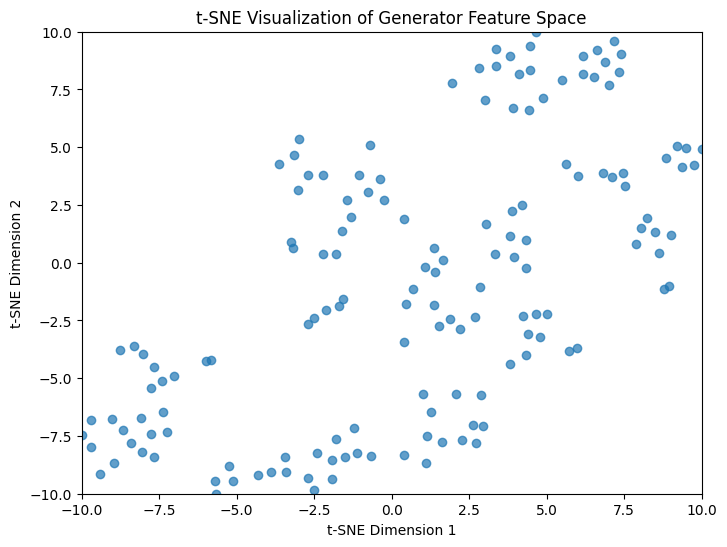

In [ ]:
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🔥 저장된 Wav2Vec2 Feature Map 불러오기
feature_dir = "feature_output_wav2vec2_rpgan"
feature_files = sorted(glob.glob(f"{feature_dir}/feature_*.npy"))

features = []

# 🔥 Feature Map 로드 (1024,)
for file_path in feature_files:
    feature_map = np.load(file_path)  # (1024,)
    features.append(feature_map)

# 🔥 NumPy 배열 변환 (이미 모든 feature가 동일한 차원)
features = np.array(features)  # (150, 1024)

print(f"✅ Feature Shape Before PCA: {features.shape}")  # (150, 1024)

# 🔥 PCA 적용 (1024 → 50차원)
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

print(f"✅ Feature Shape After PCA: {features_pca.shape}")  # (150, 50)

# 🔥 t-SNE 적용 (50 → 2차원)
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

scaler = MinMaxScaler(feature_range=(-10, 10))
features_tsne = scaler.fit_transform(features_tsne)

min_x, max_x = -10, 10
min_y, max_y = -10, 10
# 🔥 시각화
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Generator Feature Space")
plt.xlim(min_x, max_x)  # ✅ x축 범위 고정
plt.ylim(min_y, max_y)  # ✅ y축 범위 고정
plt.show()

# 하나의 Mel을 반복적으로 inference


In [ ]:
import os
import torch
import json
import glob
from scipy.io.wavfile import write

class Args:
    group_name = None
    input_wavs_dir = 'LJSpeech-1.1/wavs'
    output_dirs = 'inference_output_rpgan_0303'
    checkpoint_file = 'cp_RPGAN_R1R2_lambda(0.0005)/g_00081810.pt'
    input_validation_file = 'LJSpeech-1.1/validation.txt'
    feature_output_dir = 'feature_output_rpgan'

h = None
device = None

def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print(f"Loading checkpoint from '{filepath}'")
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Checkpoint loaded.")
    return checkpoint_dict

def get_mel(x):
    return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)

def get_inference_dataset(a, num_samples=1, start_idx=0):
    """ 하나의 Mel Spectrogram만 가져오기 """
    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]

    return validation_files[start_idx:num_samples+start_idx]  # 한 개의 파일만 선택

def inference(a):
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint(a.checkpoint_file, device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = get_inference_dataset(a, num_samples=1)  # 1개의 Mel Spectrogram만 가져오기

    os.makedirs(a.output_dirs, exist_ok=True)

    generator.eval()
    generator.remove_weight_norm()

    with torch.no_grad():
        file_path = filelist[0]  # 하나의 Mel Spectrogram만 사용

        # Mel Spectrogram 변환
        wav, sr = load_wav(file_path)
        wav = wav / MAX_WAV_VALUE
        wav = torch.FloatTensor(wav).to(device)
        x = get_mel(wav.unsqueeze(0))

        # 같은 Mel Spectrogram으로 100번 생성
        for i in range(1, 101):  # 1~100
            y_g_hat, _ = generator(x)

            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            audio = audio.cpu().numpy().astype('int16')

            # 파일명 변경 (각 반복마다 다르게 저장)
            output_filename = os.path.splitext(os.path.basename(file_path))[0] + f'_rpgan_inference_{i:03d}.wav'
            output_file = os.path.join(a.output_dirs, output_filename)

            write(output_file, h.sampling_rate, audio)
            print(f"Generated: {output_file}")

def main():
    print('Initializing Inference Process..')

    config_file = "config_v1.json"
    with open(config_file) as f:
        data = f.read()

    global h
    json_config = json.loads(data)
    h = AttrDict(json_config)

    torch.manual_seed(h.seed)
    global device
    if torch.cuda.is_available():
        torch.cuda.manual_seed(h.seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    inference(a)

if __name__ == '__main__':
    a = Args()
    main()

Initializing Inference Process..
Loading checkpoint from 'cp_RPGAN_R1R2_lambda(0.0005)/g_00081810.pt'


<ipython-input-22-f76c4eeb10b0>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(filepath, map_location=device)


Checkpoint loaded.
Removing weight norm...
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_001.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_002.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_003.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_004.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_005.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_006.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_007.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_008.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_009.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_010.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_011.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_012.wav
Generated: inference_output_rpgan_0303/LJ050-0269_rpgan_inference_013